# Project: Evaluating Algorithms to Split Single Scans with Two X-rays
## Objective: Develop a reliable method to split double X-ray scans into individual images before DICOMization
---
### Background

In the BB-Collection, we identified several TIFF scans containing two X-rays per file, most prevalently (but not exclusively) in the *Elbow*, *Foot&Ankle*, *Hand&Wrist*, *Knee* sub-folders. We need to separate these scans into individual X-ray images. 

### Strategy

We've determined two primary approaches for this task:

1. Classic Image-Processing
2. Machine Learning / Deep Learning

#### Classic Image-Processing
**Approach:** Image processing algorithms typically require some *enhancement* filter (brightness/contrast tweaking) for the *"feature detection"* step (points, edges, lines, similar areas). After adjusting a small set of parameters (threshold values), the process can run unsupervised on the entire dataset.  
**Pros:** No need for data labeling for a training pass. The process can run "unsupervised" after setting parameters.  
**Cons:** The lack of robustness. The images need to be fairly homogeneous for a successful *feature detection* pass.

#### Machine Learning / Deep Learning
**Approach:** ML/DL involves training artificial neural networks (ANN) on a labeled subset of the dataset. The *trained model* is then used for *prediction/inference* on the dataset.  
**Pros:** ANNs can recognize complex classes of objects, regardless of their position, rotation, size, etc. They are also fairly insensitive to noise.  
**Cons:** Requires the preparation of a labeled training set, which can be time-consuming.  

We will evaluate these approaches based on their potential benefits and challenges, specifically within the context of the BB-Collection.

### Logbook Entry: June 7, 2023
---
### Testing classic image-processing algorithms
#### Canny edge detection + Hough lines
Canny Edge Detection and Hough Lines Transformation are key OpenCV algorithms used for identifying and interpreting features in an image.  
The Canny algorithm effectively detects edges by reducing noise and isolating the most structurally significant boundaries.  
The Hough Lines algorithm can then interpret these edges, identifying where they align to form straight lines.  
These two algorithms are often used in conjunction due to their complementary nature: Canny outlines the main features while Hough Lines interprets these features' structure, together providing a robust method for understanding and extracting meaningful information from images.

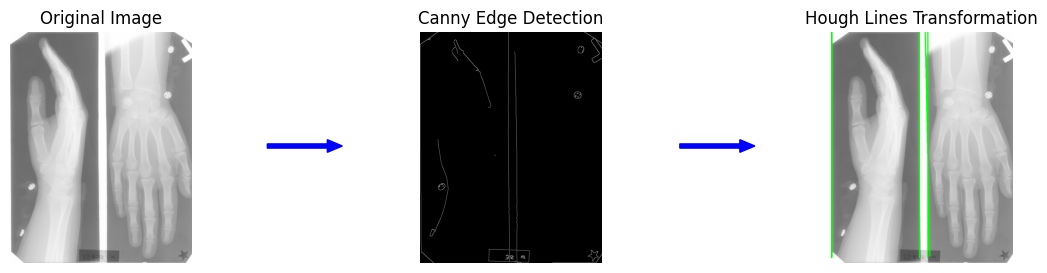

In [26]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load image
original = cv2.imread('example1.png', cv2.IMREAD_GRAYSCALE)

# Apply Canny edge detection
canny = cv2.Canny(original, 50, 150)

# Apply Hough Lines detection
lines = cv2.HoughLines(canny, 1, np.pi / 150, 200)
hough = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)  # Convert to color image for line overlay
if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * a)
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * a)
        cv2.line(hough, (x1, y1), (x2, y2), (0, 255, 0), 3)  # Draw lines in green

# Initialize the plot
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

# Show images
ax[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
ax[1].imshow(canny, cmap='gray')
ax[2].imshow(cv2.cvtColor(hough, cv2.COLOR_BGR2RGB))

# Hide axes
for a in ax:
    a.axis('off')

# Add titles
ax[0].set_title('Original Image')
ax[1].set_title('Canny Edge Detection')
ax[2].set_title('Hough Lines Transformation')

# Draw arrows between the images
arrow1 = plt.Arrow(0.35, 0.5, 0.05, 0, width=0.07, color='blue', transform=fig.transFigure, clip_on=False)
arrow2 = plt.Arrow(0.625, 0.5, 0.05, 0, width=0.07, color='blue', transform=fig.transFigure, clip_on=False)
fig.add_artist(arrow1)
fig.add_artist(arrow2)

plt.show()

In [2]:
import cv2
import numpy as np
from scipy.stats import mode
from collections import namedtuple
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from multiprocessing import Pool

In [3]:
Line = namedtuple('Line', ['x1', 'y1', 'x2', 'y2'])
step = 50
canny_lower_thresholds = list(range(50, 151, step))
canny_upper_thresholds = list(range(150, 301, step))
hough_thresholds = list(range(150, 251, step))
folder = Path('Resized 100')

In [4]:
search_space_size = len(canny_lower_thresholds) * len(canny_upper_thresholds) * len(hough_thresholds)
print(f"Search space size: {search_space_size}")

Search space size: 36


In [5]:
def FindSplit(img):
    found_lines = []
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    width = img.shape[1]
    height = img.shape[0]
    left_boundary = width * 0.2
    right_boundary = width * 0.8
    top_boundary = height * 0.2
    bottom_boundary = height * 0.8

    # Grid search over parameters
    for lower in canny_lower_thresholds:
        for upper in canny_upper_thresholds:
            edges = cv2.Canny(gray, lower, upper, apertureSize=3)
            for threshold in hough_thresholds:
                lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)
                if lines is not None:                    
                    for line in lines:
                        rho, theta = line[0]
                        a = np.cos(theta)
                        b = np.sin(theta)
                        x0 = a*rho
                        y0 = b*rho
                        x1 = int(x0 + 1000*(-b))
                        y1 = int(y0 + 1000*(a))
                        x2 = int(x0 - 1000*(-b))
                        y2 = int(y0 - 1000*(a))
                        
                        # Check if both ends of the line are within the middle 50% of the image
                        if (left_boundary <= x1 <= right_boundary and left_boundary <= x2 <= right_boundary) or (top_boundary <= y1 <= bottom_boundary and top_boundary <= y2 <= bottom_boundary):
                            found_lines.append(Line(x1, y1, x2, y2))
                            cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 5)                        
    
    # Calculate and draw the average line if there are valid lines
    '''
    if len(found_lines) > 0:
        x1s = [line.x1 for line in found_lines]
        x2s = [line.x2 for line in found_lines]
        y1s = [line.y1 for line in found_lines]
        y2s = [line.y2 for line in found_lines]
    
        med_x1 = int(np.median(x1s))
        med_x2 = int(np.median(x2s))
        med_y1 = int(np.median(y1s))
        med_y2 = int(np.median(y2s))
    
        mod_x1 = mode(x1s, keepdims=True)[0][0]
        mod_x2 = mode(x2s, keepdims=True)[0][0]
        mod_y1 = mode(y1s, keepdims=True)[0][0]
        mod_y2 = mode(y2s, keepdims=True)[0][0]
        
        cv2.line(img, (med_x1, med_y1), (med_x2, med_y2), (0, 0, 255), 10)
        cv2.line(img, (mod_x1, mod_y1), (mod_x2, mod_y2), (0, 0, 255), 10)

        # final_x1 = int(np.mean([med_x1, mod_x1]))
        # final_x2 = int(np.mean([med_x2, mod_x2]))
        # final_y1 = int(np.mean([med_y1, mod_y1]))
        # final_y2 = int(np.mean([med_y2, mod_y2]))

        # cv2.line(img, (final_x1, final_y1), (final_x2, final_y2), (0, 255, 0), 20)
    '''
    return (img, (len(found_lines) > 0))

In [6]:
scans = list(folder.rglob('*.png'))
names = ['Elbow','Foot&Ankle','Hand&Wrist', 'Knee']
filtered = [file for file in scans if file.parent.name in names]
scans = filtered

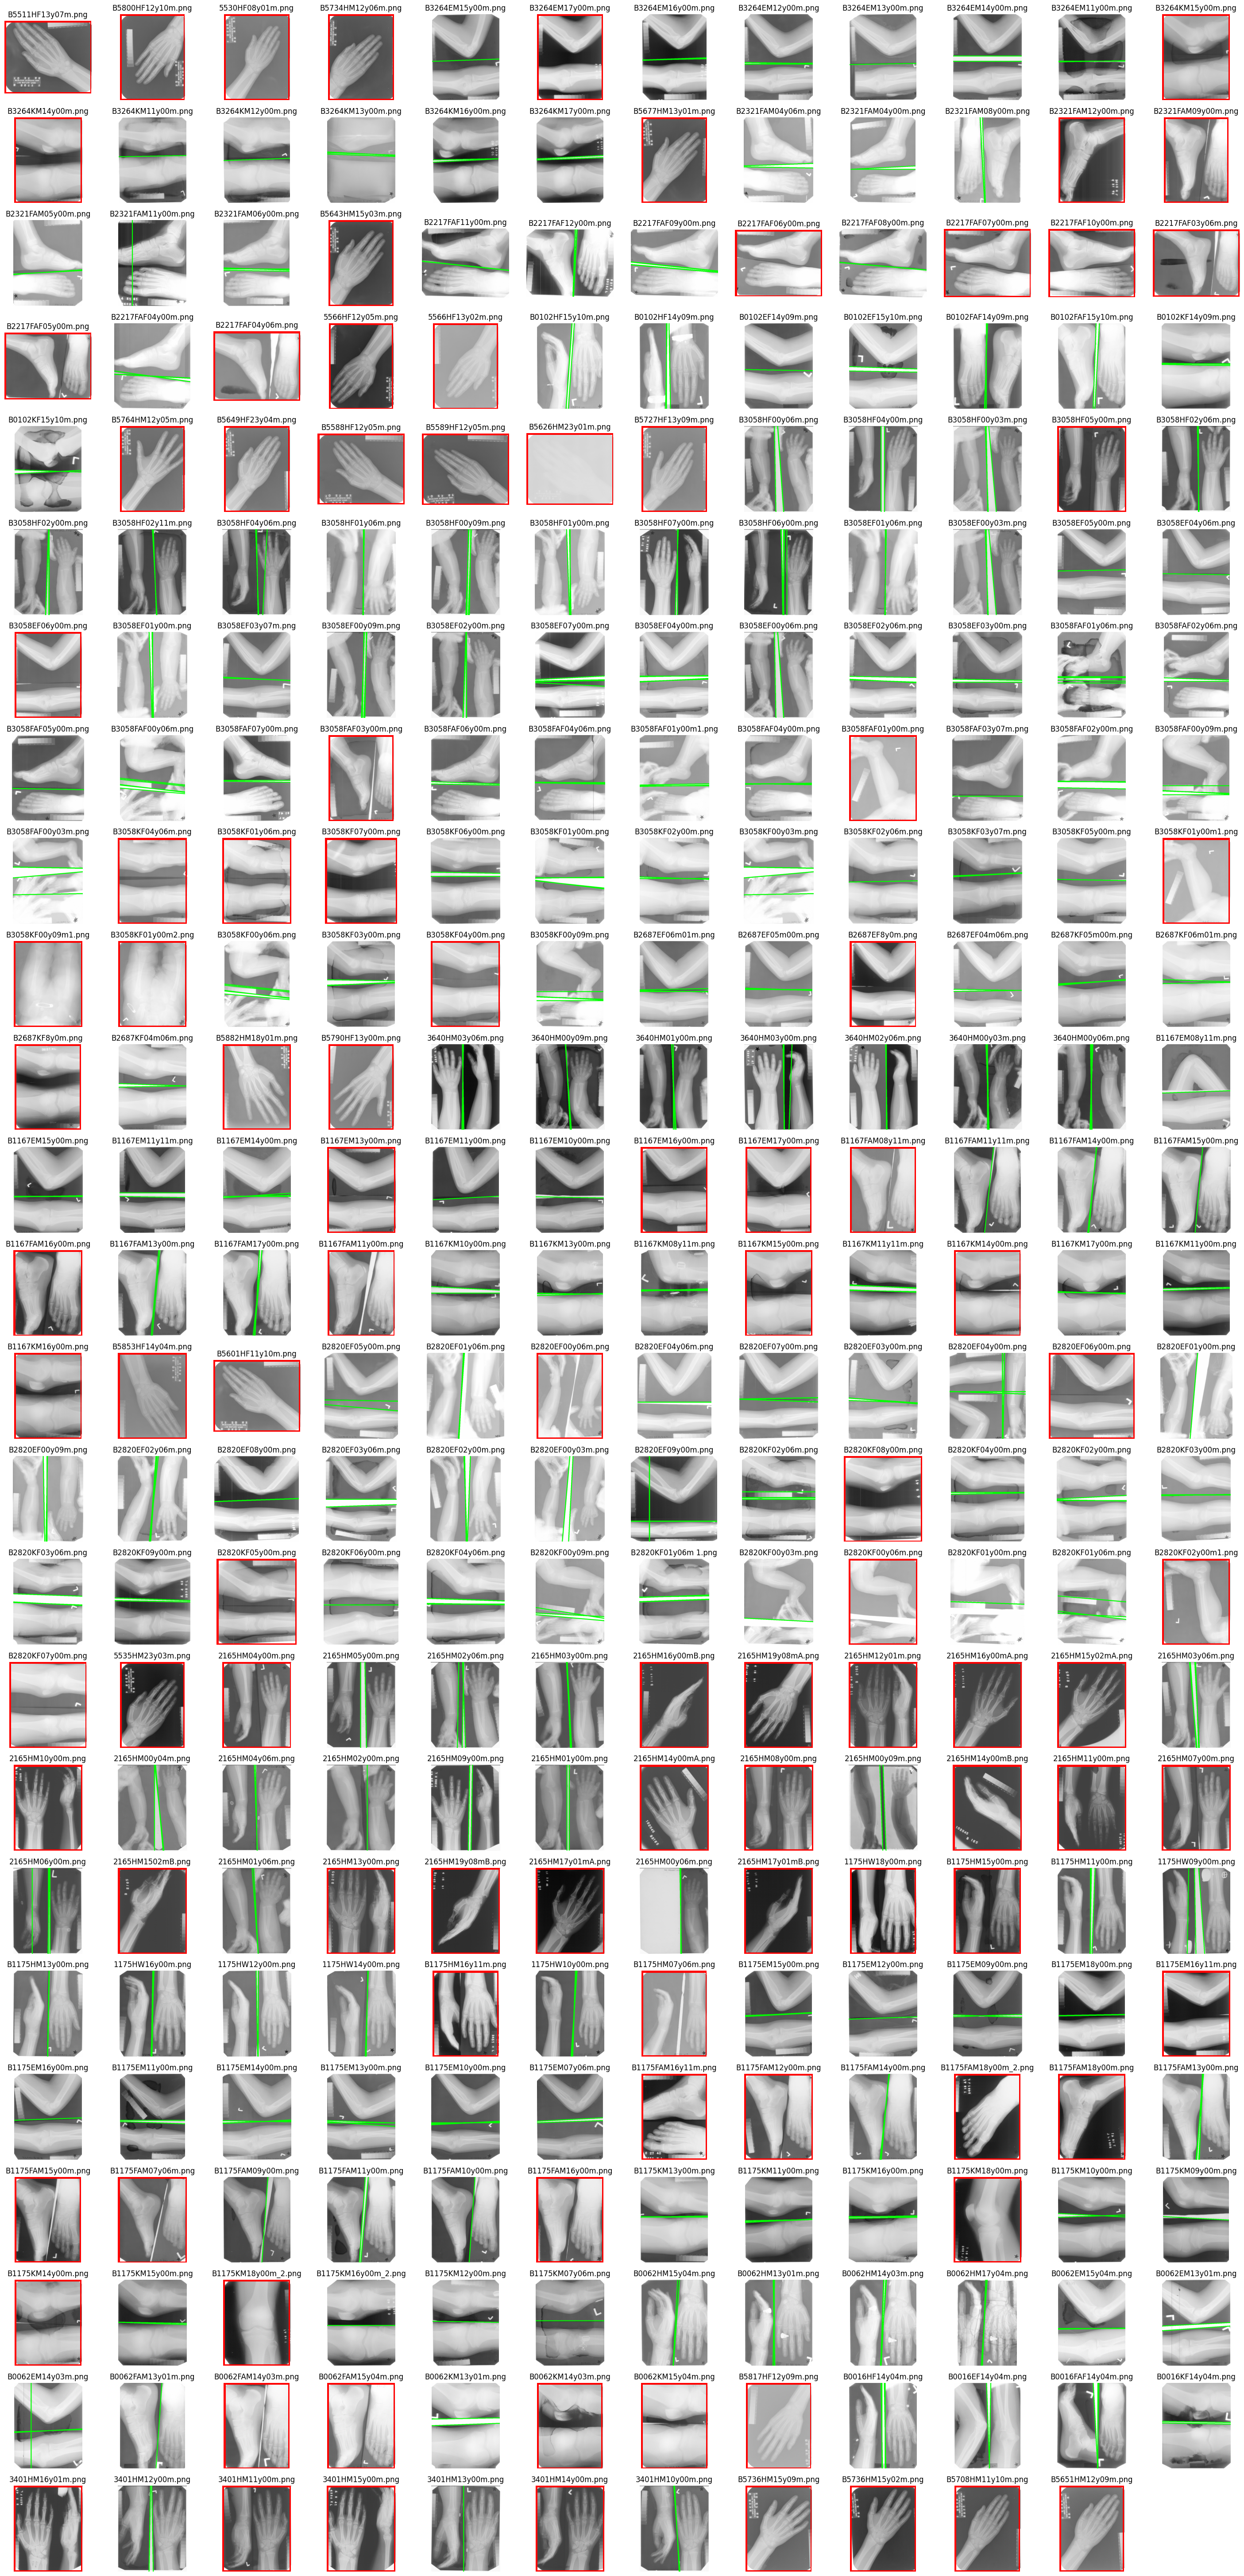

Misses/Total: 104/299


In [15]:
n_images = len(scans)
n_cols = 12
n_rows = int(np.ceil(n_images / n_cols))
# grid_size = int(np.ceil(np.sqrt(n_images)))
subplot_size = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*subplot_size, n_rows*subplot_size))
axs = axs.ravel()
# Hide empty subplots
for ax in axs[n_images:]:
    ax.axis('off')

def process_image(img_file):
    ocv_img = cv2.imread(str(img_file))
    resized = cv2.resize(ocv_img, (512, int(ocv_img.shape[0] * 512 / ocv_img.shape[1])))
    img, split = FindSplit(resized)
    rect = None
    if split == False:
        rect = patches.Rectangle((0, 0), img.shape[1], img.shape[0], linewidth=5, edgecolor='r', facecolor='none')
    return img, rect, split

with Pool() as p:
    results = p.map(process_image, scans)

misses = 0
for idx, result in enumerate(results):
    img, rect, split = result
    axs[idx].imshow(img)
    axs[idx].axis('off')
    axs[idx].set_title(scans[idx].name)
    if rect is not None:
        axs[idx].add_patch(rect)
        misses += 1

plt.show()
print(f"Misses/Total: {misses}/{len(scans)}")